In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 1. 데이터 로드 및 전처리
df = pd.read_csv('../DSA_features.csv')

In [2]:
# lying과 stepper 데이터 필터링
df = df[df['activity'].isin(['lyingRight', 'lyingBack', 'stepper'])]
df['label'] = df['activity'].apply(lambda x: 0 if x in ['lyingRight', 'lyingBack'] else 1)

# 라벨과 사람 ID, 활동명을 제외한 피처만 선택
features = df.drop(['activity', 'label', 'people'], axis=1)
labels = df['label'].values

In [3]:
# 2. 데이터 정규화 및 학습/테스트 분할
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 정상 데이터만으로 학습 데이터 구성
train_data, test_data, train_labels, test_labels = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

In [4]:
# 3. 노이즈 추가 함수 정의
def add_noise(data, noise_factor=0.5):
    noise = noise_factor * np.random.normal(size=data.shape)
    return data + noise

# 노이즈가 섞인 학습 및 테스트 데이터 생성
noised_train_data = add_noise(train_data)
noised_test_data = add_noise(test_data)

# 정상 데이터만을 학습 데이터로 사용, 타깃은 노이즈 없는 원본 데이터
train_data_normal = train_data[train_labels == 0]
noised_train_data_normal = noised_train_data[train_labels == 0]

In [5]:
# 4. Denoising Autoencoder 모델 정의 및 학습
input_dim = train_data.shape[1]
input_layer = Input(shape=(input_dim,))

# 인코더
encoder = Dense(64, activation="relu")(input_layer)
encoder = Dense(32, activation="relu")(encoder)
encoder = Dense(16, activation="relu")(encoder)

# 잠재 공간
latent_space = Dense(16, activation="relu")(encoder)

# 디코더
decoder = Dense(32, activation="relu")(latent_space)
decoder = Dense(64, activation="relu")(decoder)
output_layer = Dense(input_dim, activation="linear")(decoder)

# 모델 정의
denoising_autoencoder = Model(inputs=input_layer, outputs=output_layer)
denoising_autoencoder.compile(optimizer='adam', loss='mse')

# 모델 학습
denoising_autoencoder.fit(noised_train_data_normal, train_data_normal, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.7816 - val_loss: 0.6071
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6326 - val_loss: 0.4255
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4306 - val_loss: 0.3821
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3863 - val_loss: 0.3548
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3744 - val_loss: 0.3261
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3176 - val_loss: 0.3019
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3282 - val_loss: 0.2911
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3419 - val_loss: 0.2840
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2913 - val_loss: 0.2793
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3511 - val_loss: 0.2754
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3672 - val_loss: 0.2693
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3003 - val_l

In [6]:
# 5. 테스트 데이터에서 재구성 오류 계산
test_predictions = denoising_autoencoder.predict(noised_test_data)
mse = np.mean(np.power(test_data - test_predictions, 2), axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [7]:
# 6. 임계값 설정 및 비정상 데이터 분류
threshold = np.percentile(mse[test_labels == 0], 95)
predictions = [1 if error > threshold else 0 for error in mse]

In [8]:
# 7. 정확도 평가
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions)
print("Denoising Autoencoder Model Accuracy: {:.2f}%".format(accuracy * 100))

Denoising Autoencoder Model Accuracy: 66.67%


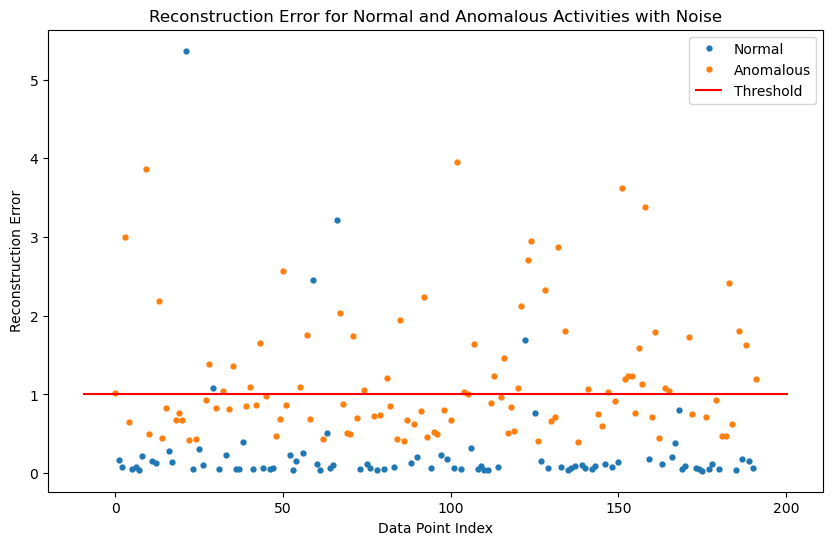

In [9]:
# 8. 시각화
import matplotlib.pyplot as plt

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': test_labels})
groups = error_df.groupby('true_class')

fig, ax = plt.subplots(figsize=(10, 6))
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', label="Anomalous" if name == 1 else "Normal")

ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error for Normal and Anomalous Activities with Noise")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()

# 위의 경우는 noised_test_data를 넣은 건데 그냥 test_data를 넣어보자.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold for anomaly detection: 1.0028772700638715
Denoising Autoencoder Model Accuracy on Test Data without Noise: 66.15%


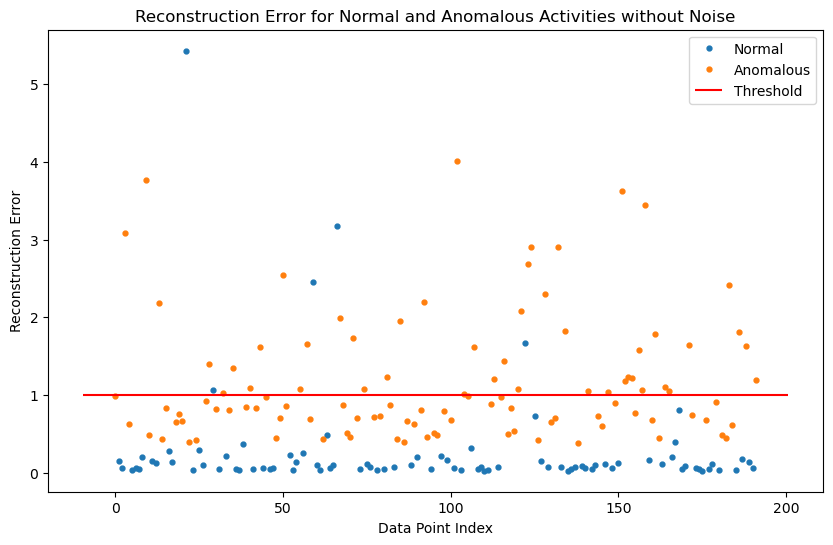

In [10]:
# 5. 테스트 데이터에서 재구성 오류 계산 (노이즈 없는 test_data 사용)
# Autoencoder를 통해 test_data의 재구성 오류 계산
test_predictions = denoising_autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_predictions, 2), axis=1)

# 6. 임계값 설정 및 비정상 데이터 분류
# 임계값 설정 (예: 정상 데이터의 95번째 백분위수)
threshold = np.percentile(mse[test_labels == 0], 95)  # 정상 데이터의 95번째 백분위수로 임계값 설정
print(f"Threshold for anomaly detection: {threshold}")

# 예측: 임계값보다 큰 오류는 비정상(1), 작은 오류는 정상(0)으로 분류
predictions = [1 if error > threshold else 0 for error in mse]

# 7. 정확도 평가
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions)
print("Denoising Autoencoder Model Accuracy on Test Data without Noise: {:.2f}%".format(accuracy * 100))

# 8. 시각화
import matplotlib.pyplot as plt

# 시각화를 위해 재구성 오류와 실제 클래스(정상/비정상)를 포함한 데이터프레임 생성
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': test_labels})
groups = error_df.groupby('true_class')

fig, ax = plt.subplots(figsize=(10, 6))
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', label="Anomalous" if name == 1 else "Normal")

ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error for Normal and Anomalous Activities without Noise")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()


# 뭔가 수정이 필요하다. 일단 보통 denoising 과정에서 성능이 더 좋아져야 할텐데, threshold 값을 조정해보도록 하겠다.

In [11]:
# 6. 임계값 설정 및 비정상 데이터 분류
threshold = np.percentile(mse[test_labels == 0], 90)
predictions = [1 if error > threshold else 0 for error in mse]

In [12]:
# 7. 정확도 평가
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions)
print("Denoising Autoencoder Model Accuracy: {:.2f}%".format(accuracy * 100))

Denoising Autoencoder Model Accuracy: 95.31%


# threshhold 값을 조정해 성능은 좋아졌으나. 원체 성능이 좋았던터라 linear와 차이를 느끼기 힘들다.
# 차후 수정을 하거나 stepper 대신 다른 속성을 넣어보도록 하겠다.